#  scidx_streaming URL Registration

This notebook crawls the public index at:

**https://horel.chpc.utah.edu/data/meop/data/**

It extracts file links (recursively), filters them to only include files whose **filename contains a year ≥ 2020**, and then **registers** those URLs into your **`scidx_streaming`** deployment.

> **Note:** You will need valid credentials and the correct POP/API endpoint for your `scidx_streaming` instance. This notebook includes a dry-run mode so you can verify which URLs would be registered before actually registering them.

In [5]:
from ndp_ep import APIClient
from scidx_streaming import StreamingClient
import os, datetime
import pandas as pd
from dotenv import load_dotenv
import os
from helper_func import register_kafka
import time
import json
import numpy as np
import matplotlib.pyplot as plt
# ---- Configuration ----
load_dotenv(override=True)


# Registration settings
# read token from .env file
TOKEN = os.getenv("TOKEN")
API_URL = os.getenv("API_URL")
SERVER = os.getenv("SERVER")

# Kafka Configuration
KAFKA_HOST = os.getenv("KAFKA_HOST")
KAFKA_PORT = os.getenv("KAFKA_PORT")
BOOTSTRAP = f"{KAFKA_HOST}:{KAFKA_PORT}"
CHUNK_SIZE = 25_000  # starting rows per message
SOFT_CAP_BYTES = 950_000  # stay under common 1MB broker limit

# initializing ndp_ep APIClient
client = APIClient(base_url=API_URL, token=TOKEN)
streaming = StreamingClient(client)
print(f"Streaming Client initialized. User ID: {streaming.user_id}")
date_time_now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
org_name = "kafka_stream"

bus13_urls = [
    # "https://horel.chpc.utah.edu/data/meop/level3/ebus_2024/ebus_min_2024_12.csv",
    "https://horel.chpc.utah.edu/data/meop/level3/ebus_2025/ebus_min_2025_01.csv"
    # "https://horel.chpc.utah.edu/data/meop/data/BUS12_2024_12.csv",
    # "https://horel.chpc.utah.edu/data/meop/data/BUS12_2025_01.csv"
]

# pandas configuration
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)



Streaming Client initialized. User ID: fc624925-ef09-447d-bf16-378066799275


In [6]:
# list all topic of kafka
register_kafka(bus13_urls, org_name, client, BOOTSTRAP, KAFKA_HOST, KAFKA_PORT, SERVER)

{'id': 'b73c7968-786b-43a8-96f4-f7e7b5bba6c9'}


In [7]:
# print(client.search_datasets("kafka_ebus_min_2024_12-csv", server=SERVER))
print(client.search_datasets("kafka_ebus_min_2025_01-csv", server=SERVER))

[{'id': 'b73c7968-786b-43a8-96f4-f7e7b5bba6c9', 'name': 'kafka_ebus_min_2025_01-csv', 'title': 'Kafka Sensor Data – ebus min 2025 01', 'owner_org': 'kafka_stream', 'notes': "The kafka stream is generated from csv dataset. This dataset is available at https://horel.chpc.utah.edu/data/meop/level3/ebus_2025/ebus_min_2025_01.csv. Vehicle: E-bus Data period: 2025-01 File type: CSV File marked 'min' appears to be minute-resolution of data. File marked 'meop' (Mobile Environment Observation Platform) where sensors are attached to UTA. Data processing level: Level 3 (modified on Level 2 data)", 'resources': [{'id': '47199550-adce-4968-885c-8688b2f331ac', 'url': '', 'name': 'ebus_min_2025_01-csv', 'description': 'Kafka topic ebus_min_2025_01-csv hosted at 10.244.2.206:9092', 'format': 'kafka'}], 'extras': {'host': '10.244.2.206', 'port': '9092', 'topic': 'ebus_min_2025_01-csv'}}]


In [8]:
stream = await streaming.create_kafka_stream(
    keywords=["kafka_ebus_min_2025_01-csv"],
    match_all=True,
    filter_semantics=[]
)

topic1 = stream.data_stream_id
print(f"Stream created: {topic1}")

Stream created: data_stream_fc624925-ef09-447d-bf16-378066799275_1


Heartbeat session expired - marking coordinator dead
Heartbeat session expired - marking coordinator dead
Heartbeat session expired - marking coordinator dead
Failed fetch messages from 1: KafkaConnectionError: Connection at 10.244.2.206:9092 closed
Heartbeat session expired - marking coordinator dead
Failed fetch messages from 1: [Error 7] RequestTimedOutError
Heartbeat session expired - marking coordinator dead


In [21]:
#consumer1 = streaming.consume_kafka_messages(topic1)
consumer1 = streaming.consume_kafka_messages("data_stream_fc624925-ef09-447d-bf16-378066799275_1")

In [ ]:
df1 = consumer1.dataframe
# df1 = pd.DataFrame(df1)
# df1 = pd.DataFrame(df1.iloc[0].to_dict())
# df1.reset_index(drop=True, inplace=True)
print(df1)

                     time pm2.5   pm10    o3 pmf o3f
0     2024-12-01 05:04:00                      0   0
1     2024-12-01 05:05:00                2.2   0   0
2     2024-12-01 05:06:00   9.8   28.9   2.3   0   0
3     2024-12-01 05:07:00   9.6   23.8   2.6   0   0
4     2024-12-01 05:08:00   9.3   20.9   2.9   0   0
5     2024-12-01 05:09:00   9.2   21.3   2.2   0   0
6     2024-12-01 05:10:00   9.1   19.5   2.2   0   0
7     2024-12-01 05:11:00   9.0   17.4   1.4   0   0
8     2024-12-01 05:12:00   9.3   18.7   2.4   0   0
9     2024-12-01 05:13:00   9.3   18.0   2.1   0   0
10    2024-12-01 05:14:00   9.4   25.8   1.5   0   0
11    2024-12-01 05:15:00  10.1   28.7   2.6   0   0
12    2024-12-01 05:16:00  10.6   36.4   2.3   0   0
13    2024-12-01 05:17:00  10.6   35.7   2.0   0   0
14    2024-12-01 05:18:00  10.0   31.5   1.8   0   0
15    2024-12-01 05:19:00   9.2   29.2   0.2   0   0
16    2024-12-01 05:20:00   9.6   29.6   2.4   0   0
17    2024-12-01 05:21:00   8.7   28.4   1.6  

In [23]:
consumer1.stop()

In [14]:
consumer = streaming.consume_kafka_messages("data_stream_fc624925-ef09-447d-bf16-378066799275_1")
time.sleep(5)
df = None
try:
    row_count = 0
    count = 1
    while row_count < 400000:
        df = consumer.dataframe
        if not df.empty:
            df.to_csv("sensor_data.csv",index=False, mode="a")
            length_df = len(df)
            row_count += length_df
            if row_count > count*200:
                count += 1
                print(f"df row_count: {row_count}")
        del df
        df = None
except KeyboardInterrupt as e:
    print(e)
finally:
    consumer.stop()
    if df is not None and not df.empty:
        row_count += len(df)
        print(f"df row_count: {row_count}")
        df.to_csv("sensor_data.csv",index=False, mode="a")
        del df

df row_count: 201
df row_count: 401
df row_count: 601
df row_count: 801
df row_count: 1001
df row_count: 1201
df row_count: 1401
df row_count: 1601
df row_count: 1801
df row_count: 2001
df row_count: 2201
df row_count: 2401
df row_count: 2601
df row_count: 2801
df row_count: 3001
df row_count: 3201
df row_count: 3401
df row_count: 3601
df row_count: 3801
df row_count: 4001
df row_count: 4201
df row_count: 4401
df row_count: 4601
df row_count: 4801
df row_count: 5001
df row_count: 5201
df row_count: 5401
df row_count: 5601
df row_count: 5801
df row_count: 6001
df row_count: 6201
df row_count: 6401
df row_count: 6601
df row_count: 6801
df row_count: 7001
df row_count: 7201
df row_count: 7401
df row_count: 7601
df row_count: 7801
df row_count: 8001
df row_count: 8201
df row_count: 8401
df row_count: 8601
df row_count: 8801
df row_count: 9001
df row_count: 9201
df row_count: 9401
df row_count: 9601
df row_count: 9801
df row_count: 10001
df row_count: 10201
df row_count: 10401
df row_count:

In [5]:
stream2 = await streaming.create_kafka_stream(
    keywords=["kafka_ebus_min_2025_01-csv"],
    match_all=True,
    filter_semantics=[]
)

topic2 = stream2.data_stream_id
print(f"Stream created: {topic2}")

Stream created: data_stream_fc624925-ef09-447d-bf16-378066799275_2


In [6]:
# consumer2 = streaming.consume_kafka_messages(topic2)
consumer2 = streaming.consume_kafka_messages("data_stream_fc624925-ef09-447d-bf16-378066799275_2")

In [7]:
df2 = consumer2.dataframe
df2 = pd.DataFrame(df2)
df2 = pd.DataFrame(df2.iloc[0].to_dict())
# df1.reset_index(drop=True, inplace=True)
print(df2)

                     time pm2.5   pm10    o3 pmf o3f
0     2025-01-01 00:00:00               31.3   0   0
1     2025-01-01 00:00:00               29.8   0   0
2     2025-01-01 00:00:00               21.5   0   0
3     2025-01-01 00:00:00               22.6   0   0
4     2025-01-01 00:00:00               13.2   0   0
5     2025-01-01 00:00:00               14.3   0   0
6     2025-01-01 00:00:00               25.6   0   0
7     2025-01-01 00:00:00               34.2   0   0
8     2025-01-01 00:00:00               21.0   0   0
9     2025-01-01 00:00:00               24.7   0   0
10    2025-01-01 00:00:00               25.9   0   0
11    2025-01-01 00:00:00               31.6   0   0
12    2025-01-01 00:00:00                      0   0
13    2025-01-01 00:01:00               30.5   0   0
14    2025-01-01 00:01:00               30.5   0   0
15    2025-01-01 00:01:00                      0   0
16    2025-01-01 00:01:00   1.5    8.9         0   0
17    2025-01-01 00:01:00   0.9    2.5  21.8  

In [19]:
consumer2.stop()

In [9]:
df1c = df1.copy()
df2c = df2.copy()

In [90]:
await streaming.delete_stream('all')

{'message': 'No streams found to delete.'}

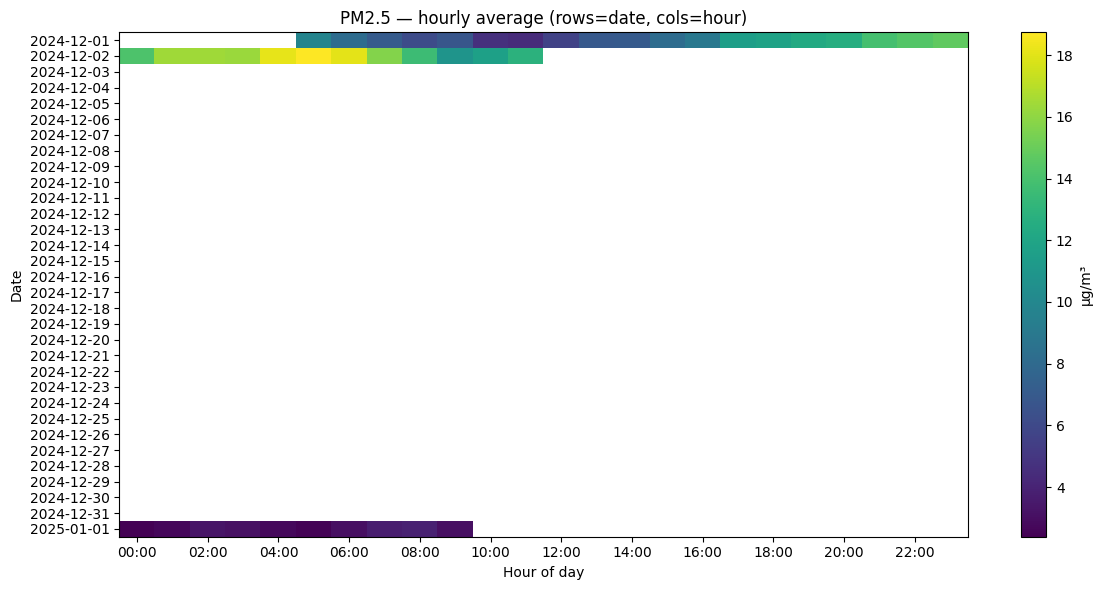

In [13]:
df = pd.concat([df1c, df2c], ignore_index=True)

# Keep only time + pm2.5
df = df[["time","pm2.5"]].copy()

# Parse time and coerce pm2.5 to numeric
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df["pm2.5"] = pd.to_numeric(df["pm2.5"], errors="coerce")

# Drop rows with missing timestamp
df = df.dropna(subset=["time"]).sort_values("time")

# treat zeros as missing if zero means "no reading" in your logger
df.loc[df["pm2.5"] == 0, "pm2.5"] = np.nan

# ---- 2) Aggregate to hourly averages (keeps it smooth & reduces gaps) -------
df = df.set_index("time").resample("1h")["pm2.5"].mean()

# ---- 3) Build date x hour matrix --------------------------------------------
heat = df.to_frame(name="pm2.5")
heat["date"] = heat.index.date
heat["hour"] = heat.index.hour
heat = heat.pivot(index="date", columns="hour", values="pm2.5").sort_index()

# ---- 4) Plot heat map (very simple) -----------------------------------------
plt.figure(figsize=(12, 6))
plt.imshow(heat, aspect="auto")  # use default colormap; no custom colors
plt.title("PM2.5 — hourly average (rows=date, cols=hour)")
plt.xlabel("Hour of day")
plt.ylabel("Date")
plt.colorbar(label="µg/m³")
# Put readable ticks
plt.xticks(ticks=range(0, 24, 2), labels=[f"{h:02d}:00" for h in range(0, 24, 2)])
plt.yticks(ticks=range(len(heat.index)), labels=heat.index.astype(str))
plt.tight_layout()
plt.show()
